In [49]:
import os
import glob
import cv2
import numpy as np 
import matplotlib.pyplot as plt 
import glob

from matplotlib_inline.backend_inline import set_matplotlib_formats
set_matplotlib_formats('svg')

In [18]:
def load_dataset(dataset_dir):
    dataset_list = []
    # Note: It's very important to load the images in the correct numerical order!
    for image_file in sorted(glob.glob(os.path.join(dataset_dir, "*.png")), key=lambda x: int(x.split("/")[-1].replace(".png", ""))):
        dataset_list.append(cv2.imread(str(image_file), cv2.IMREAD_GRAYSCALE))
    return np.stack(dataset_list, axis=0)

In [20]:
data_train = load_dataset("../data/x-train")
print(f"Data train shape: {data_train.shape}")

Data train shape: (2000, 512, 512)


In [21]:
data_annotated = data_train[200:400] 

In [22]:
import pandas as pd

labels_train = pd.read_csv("../data/y_train.csv", index_col=0).T

In [66]:
print(labels_train.values.shape)

(2000, 262144)


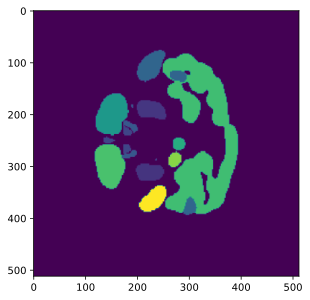

In [65]:
for index, row in labels_train.iterrows():
    plt.imshow(row.values.reshape((512, 512)))
    break

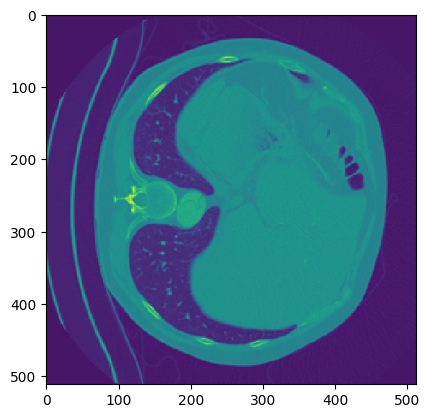

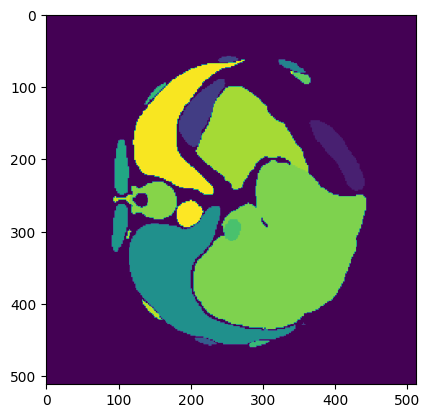

In [23]:
j = 10

i = 200 + j 
map = labels_train.iloc[i].values.reshape((512,512))

import matplotlib.pyplot as plt 

plt.imshow(data_annotated[j])
plt.figure()
plt.imshow(map)

In [24]:
map = labels_train.iloc[i].values
print(map.shape)
a = set(map)
a.remove(0)
print(a)

(262144,)
{9, 19, 22, 24, 31, 47, 52, 55, 62, 70, 71, 74, 79, 84, 85, 90, 91, 94, 95, 103, 104}


In [37]:
def split_masks(mask):
    """
    :param mask: ndarray, shape (512x512,). 
    Will be reshaped to original image shape (512, 512)
    """
    # classes values, remove background (0)
    cls_values = set(mask)
    cls_values.remove(0)

    cls_mask_l = np.zeros((len(cls_values), 512, 512), dtype=np.uint8)
    for i, cls_v in enumerate(cls_values):
        idxs = np.where(mask == cls_v)[0]
        cls_mask = np.zeros_like(mask, dtype=np.uint8)
        cls_mask[idxs] = 1
        cls_mask_l[i] = cls_mask.reshape((512, 512))

    return cls_mask_l

(21, 512, 512)


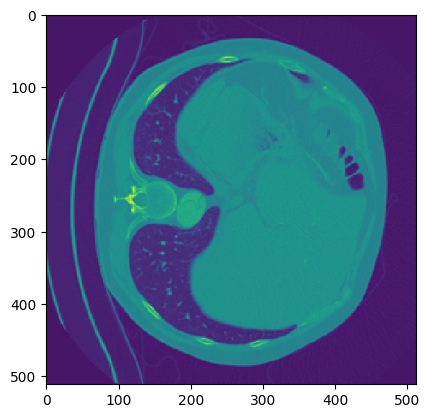

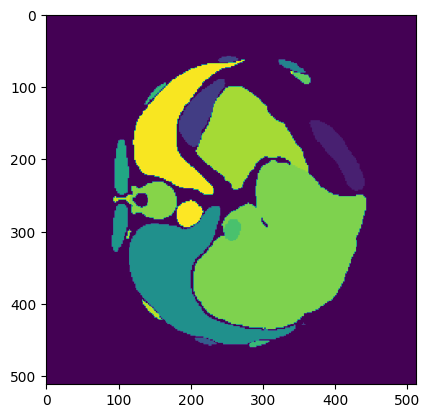

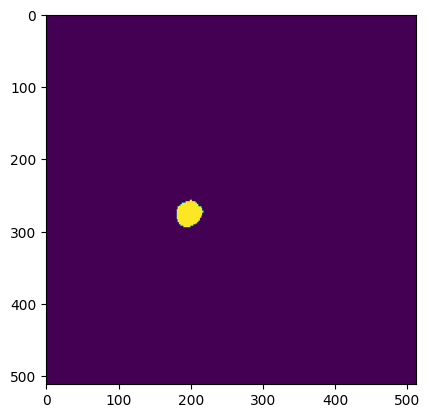

In [38]:
# test 
j = 10
i = 200 + j 
map = labels_train.iloc[i].values.reshape((512,512))

plt.imshow(data_annotated[j])
plt.figure()
plt.imshow(map)

mask = labels_train.iloc[i].values
l = split_masks(mask)
print(l.shape)

plt.figure()
plt.imshow(l[20])

In [39]:
# working prototype
import cv2

im = cv2.imread('/Users/eustachelebihan/Development/radium-challenge/data/x-train/0.png', cv2.IMREAD_GRAYSCALE)
ret, thresh = cv2.threshold(im , 127, 255, 0)
contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

im_with_contours = cv2.cvtColor(im, cv2.COLOR_GRAY2BGR)

# Draw contours on the copied image (im_with_contours)
# cv2.drawContours(im_with_contours, contours, -1, (0, 0, 255), 2)  # Draw all contours in red with thickness 2

# # Display the original image with contours
# cv2.imshow('Original Image with Contours', im_with_contours)
# cv2.waitKey(0)
# cv2.destroyAllWindows()

class:  ndarray
shape:  (512, 512)
strides:  (512, 1)
itemsize:  1
aligned:  True
contiguous:  True
fortran:  False
data pointer: 0x4100d8000
byteorder:  little
byteswap:  False
type: uint8
None


In [114]:
mask = l[20]
mask[mask == 1] = 255


ret, thresh = cv2.threshold(im, 127, 255, 0)

# # Find contours in the mask image
contours1, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Create an empty image to draw the boundary
boundary_image = np.zeros_like(mask)

# Draw contours on the boundary image
cv2.drawContours(boundary_image, contours, -1, (255), thickness=1)

# Erode the boundary image to create a region inside the boundary
kernel = np.ones((3,3), np.uint8)
eroded_boundary = cv2.erode(boundary_image, kernel, iterations=1)

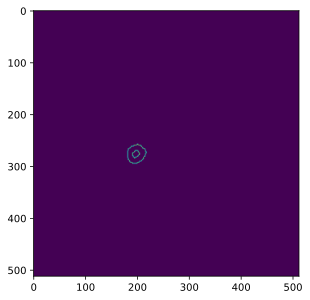

In [115]:
kernel = np.ones((3,3), np.uint8)
eroded = cv2.erode(mask, kernel, iterations=8)
contours2, _ = cv2.findContours(eroded, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)


boundary_image = np.zeros_like(mask)
cv2.drawContours(boundary_image, contours1, -1, (255), thickness=1)
cv2.drawContours(boundary_image, contours2, -1, (255), thickness=1)

plt.imshow(boundary_image)
# fig, axs = plt.subplots(1, 2, figsize=(20,20))

# axs[0].imshow(mask)
# axs[1].imshow(eroded_boundary)

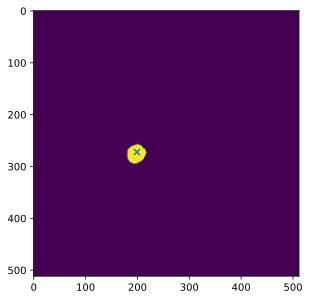

In [117]:
import random

v = np.where(eroded != 0)
idxs = [
    t_idx for t_idx in zip(v[0], v[1])
]


idx = random.choice(idxs)

plt.imshow(mask)
plt.scatter(idx[1], idx[0], marker="x")
# plt.scatter(v[0], idx[0], marker="x")

In [63]:
def erode_boundary(mask):
    """
    :param mask: ndarray of shape (512, 512), map of 0 and 1
    :return eroded_mask: new mask, eroded.
    """
    kernel = np.ones((3,3), np.uint8)
    eroded_mask = cv2.erode(mask, kernel, iterations=6)

    return eroded_mask
    

In [4]:
from prepare_dataset import load_dataset
import pandas as pd

x_train_path = "/Users/eustachelebihan/Development/radium-challenge/data/x-train"
y_train_path = "/Users/eustachelebihan/Development/radium-challenge/data/y_train.csv"

idx_start = 200
idx_end = 400

print("loading data...")
data_train = load_dataset(x_train_path)
data_train = data_train[idx_start: idx_end] 

# load masks
labels_train = pd.read_csv(y_train_path, index_col=0).T
labels_train = labels_train.values[idx_start: idx_end]
print("data loaded !")

loading data...
data loaded !


In [32]:
from tqdm import tqdm
import random
import numpy as np
from prepare_dataset import split_masks, erode_boundary


# split into 0-1 masks, erode boundary and select random point
splitted_masks, pnts = [], []
print("splitting masks...")
for mask in tqdm(labels_train[:1]):
    s_masks = split_masks(mask)
    img_pnts = np.zeros((len(s_masks), 2), dtype=np.uint16)
    for i, m in enumerate(s_masks):
        eroded_mask = erode_boundary(m)
        # pick a random point in the eroded mask
        coordinates = np.argwhere(eroded_mask == 1)
        idx = random.randint(0, len(coordinates) - 1)
        img_pnts[i] = coordinates[idx]
        print(coordinates[idx])
    splitted_masks.append(s_masks)
    pnts.append(img_pnts)

splitting masks...


100%|██████████| 1/1 [00:00<00:00, 17.30it/s]

[247 277]
[265 275]
[264 231]
[361 293]
[288 296]
[307 261]
[315  44]
[201 226]
[ 62 195]
[338 205]
[414 313]
[244 181]
[ 70 223]
[222  58]
[466 252]
[432 157]


In [33]:
print(pnts)

[array([[247, 277],
       [265, 275],
       [264, 231],
       [361, 293],
       [288, 296],
       [307, 261],
       [315,  44],
       [201, 226],
       [ 62, 195],
       [338, 205],
       [414, 313],
       [244, 181],
       [ 70, 223],
       [222,  58],
       [466, 252],
       [432, 157]], dtype=uint16)]


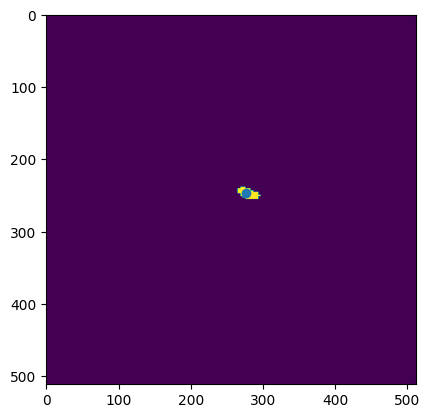

In [34]:
import matplotlib.pyplot as plt

i = 0
plt.imshow(splitted_masks[i][0])
plt.scatter(pnts[i][0,1], pnts[i][0,0])

In [40]:
import yaml

# Load YAML config file
with open('config.yaml', 'r') as file:
    config_dict = yaml.safe_load(file)

In [44]:
from easydict import EasyDict

# Convert dictionary to EasyDict
config = EasyDict(config_dict)

In [47]:
config.parameters.model_type

'vit_h'

In [53]:
import torch

state_dict = torch.load("parameters/medsam_vit_b.pt", map_location=torch.device('cpu'))
torch.save(state_dict, 'medsam_vit_b_cpu.pt')

In [2]:
from segment_anything.utils.transforms import ResizeLongestSide

In [22]:
import numpy as np

bins = [0, 100, 200, 300]
print(np.digitize(250, bins)-1)

2
